In [130]:
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import torch
import random
import torch.nn.functional as F

In [131]:
with open("expression_db.json") as f:
    db = json.load(f)

reverse_database = {(value[0], value[1]) : key for key, value in db.items()}

In [132]:
all_premises = []
premise_labels = []
premise_idx = []
# take most frequent libraries for analysis
for i, (key, value) in enumerate(db.items()):
    if value[0] == "pred_set" or value[0] == "relation" or value[0] == "list":# or value[0] == "rich_list" or value[0] == "prim_rec": #or value[0] == "pred_set" or value[0] == "set":
        all_premises.append(key)
        premise_labels.append(value[0])
        premise_idx.append(i)

In [133]:

with open('vanilla_embs.pk', 'rb') as f:
    original_embeddings = pickle.load(f)

with open('gnn_embs.pk', 'rb') as f:
    gnn_embeddings = pickle.load(f)


In [134]:
from sklearn.manifold import TSNE
import plotly.express as px
def plot_reps(reps, labels, n_components, graph_name):
    tsne = TSNE(n_components)
    tsne_result = tsne.fit_transform(reps.detach().cpu().numpy())

    color_dict = {}

    i = 0

    labels_ = list(set(labels))
    for label in labels_:
        color_dict[label] = i
        i += 1

    color_dict["POI1"] = i + 1
    color_dict["POI2"] = i + 1
    color_dict["POI3"] = i + 1
    color_dict["POI4"] = i + 1

    if n_components == 3:

        df_list = []
        for i, premise in enumerate(all_premises):
            # set custom markers for points of interest
            if i == 1255 or i == 1256 or i == 1290 or i == 1291:
                labels[i] = "POI1"
            if i == 403 or i == 418:
                labels[i] = "POI2"
            if i == 497 or i == 387:
                labels[i] = "POI3"
            if i == 1097 or i == 810 or i == 591:
                labels[i] = "POI4"
            df_list.append({'Premise': db[premise][-1], 'X': tsne_result[i,0], "Y": tsne_result[i,1], "Z": tsne_result[i,2], "Thm": premise_labels[i], "Idx": i})

        df = pd.DataFrame.from_records(df_list)


        fig = px.scatter_3d(df, x = 'X', y = 'Y', z = 'Z', color = 'Thm', hover_name = "Premise", hover_data = ["Thm", "Idx"])
        fig.update_traces(marker_size = 3)

        fig.write_html(graph_name+".html", auto_open=True)
    elif n_components == 2:
        ax = plt.figure(figsize=(16,10)).gca()
        scatter = ax.scatter(x = tsne_result[:,0], y = tsne_result[:,1], c = [color_dict[l] for l in labels])#, label = labels_th)

        legend1 = ax.legend(*(scatter.legend_elements()[0], labels_),
                        loc="lower left", title="Classes", fontsize=16)
        ax.add_artist(legend1)
        plt.savefig(graph_name, format='pdf')

        plt.show()
    else:
        raise NotImplementedError

    return tsne_result, premise_labels



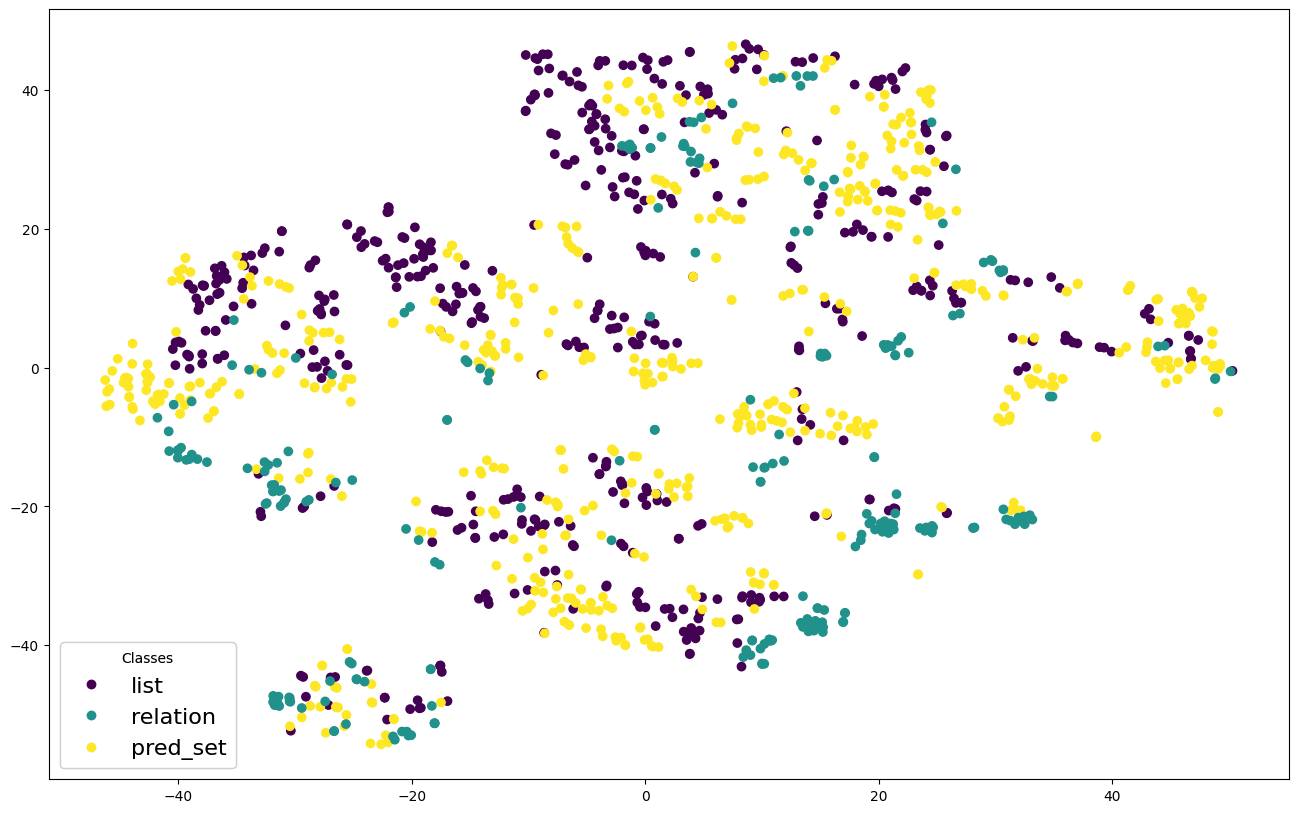

In [135]:
vanilla_tsne, v_labs = plot_reps(original_embeddings, premise_labels, 2, "original_premise_embeddings.pdf")

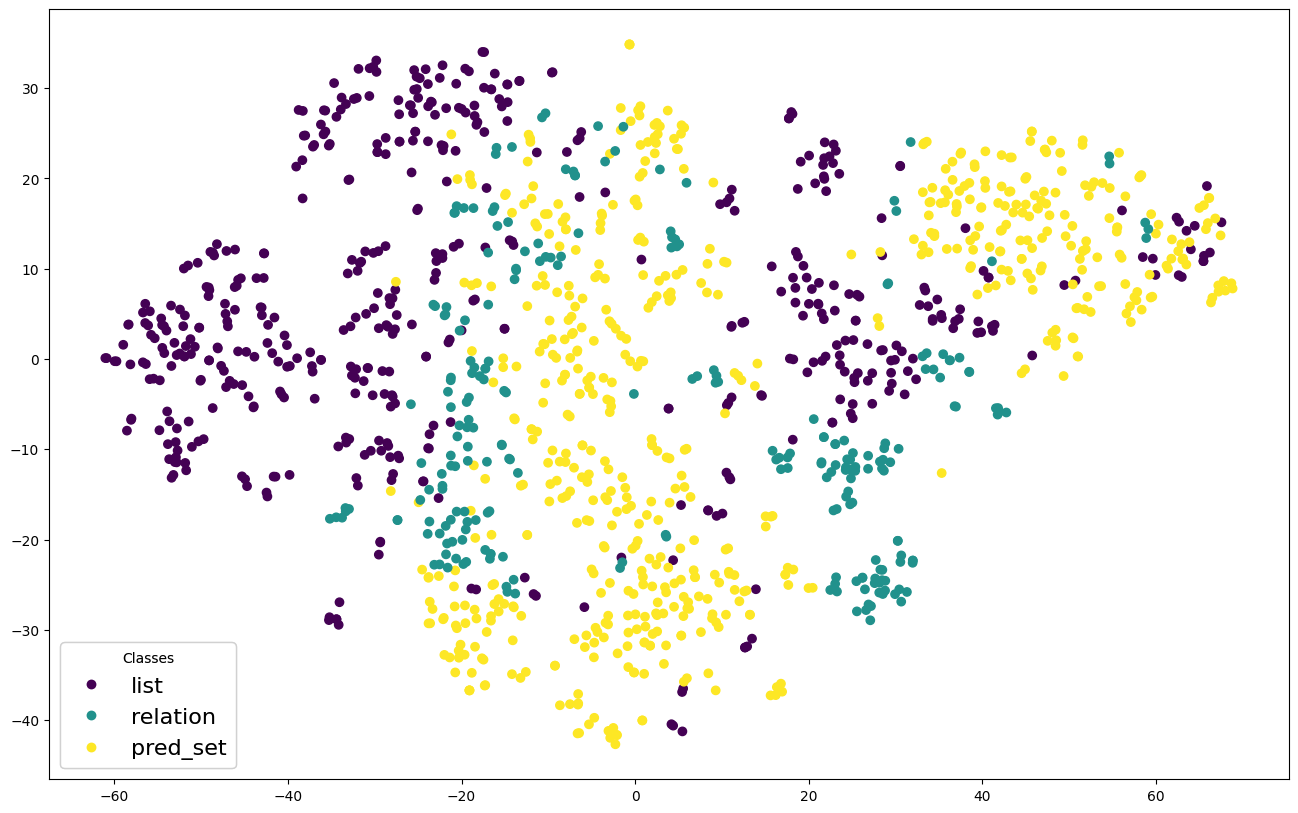

In [136]:
gnn_tsne, g_labs = plot_reps(gnn_embeddings, premise_labels, 2, "gnn_premise_embeddings.pdf")

In [116]:
vanilla_tsne, v_labs = plot_reps(original_embeddings, premise_labels, 3, "original_premise_embeddings")

In [117]:
gnn_tsne, g_labs = plot_reps(gnn_embeddings, premise_labels, 3, "gnn_premise_embeddings")

In [82]:
cos = lambda m: F.normalize(m) @ F.normalize(m).t()

In [83]:
original_cosine_closest = {}
gnn_cosine_closest = {}
def get_closest(ind):
    inds = torch.topk(cos(original_embeddings)[ind], 5)[1][1:]
    original_cosine_closest[db[all_premises[ind]][-1]] = [db[all_premises[x]][-1] for x in inds]
    inds = torch.topk(cos(gnn_embeddings)[ind], 5)[1][1:]
    gnn_cosine_closest[db[all_premises[ind]][-1]] = [db[all_premises[x]][-1] for x in inds]


In [84]:
for i in range(len(all_premises)):
    get_closest(i)
    

In [85]:
gnn_cosine_closest

{'FINITE ùïå(:Œ± # Œ≤) ‚áî FINITE ùïå(:Œ±) ‚àß FINITE ùïå(:Œ≤)': ['INFINITE ùïå(:Œ±) ‚áî ‚àÄ(s :Œ± -> bool). FINITE s ‚áí s ‚äÇ ùïå(:Œ±)',
  'INFINITE ùïå(:Œ±) ‚áî ‚àÉ(f :Œ± -> Œ±). (‚àÄ(x :Œ±) (y :Œ±). f x = f y ‚áí x = y) ‚àß ‚àÉ(y :Œ±). ‚àÄ(x :Œ±). f x ‚â† y',
  '‚àÄ(P :Œ± -> bool) (Q :Œ≤ -> bool). FINITE P ‚àß FINITE Q ‚áí FINITE ((P √ó Q) :Œ± # Œ≤ -> bool)',
  'FINITE (POW (s :Œ± -> bool)) ‚áî FINITE s'],
 'LIST_REL (R :Œ± -> Œ≤ -> bool) (l1 :Œ± list) (l2 :Œ≤ list) ‚àß LIST_REL R (l3 :Œ± list) (l4 :Œ≤ list) ‚áí LIST_REL R (l1 ++ l3) (l2 ++ l4)': ['LENGTH (x1 :Œ± list) = LENGTH (x2 :Œ≤ list) ‚áí (LIST_REL (R :Œ± -> Œ≤ -> bool) (x1 ++ (y1 :Œ± list)) (x2 ++ (y2 :Œ≤ list)) ‚áî LIST_REL R x1 x2 ‚àß LIST_REL R y1 y2)',
  'LIST_REL (R :Œ± -> Œ≤ -> bool) (l1 :Œ± list) (l2 :Œ≤ list) ‚àß LIST_REL R (l3 :Œ± list) (l4 :Œ≤ list) ‚áî LIST_REL R (l1 ++ l3) (l2 ++ l4) ‚àß LENGTH l1 = LENGTH l2 ‚àß LENGTH l3 = LENGTH l4',
  '‚àÄ(xs :Œ± list) (ys :Œ≤ list) (xs1 :Œ± list) (ys1 :Œ≤ list). LIST_

In [86]:
original_cosine_closest

{'FINITE ùïå(:Œ± # Œ≤) ‚áî FINITE ùïå(:Œ±) ‚àß FINITE ùïå(:Œ≤)': ['COUNTABLE ùïå(:Œ± # Œ≤) ‚áî COUNTABLE ùïå(:Œ±) ‚àß COUNTABLE ùïå(:Œ≤)',
  '(s1 :Œ± -> bool) ‚äÜ (s2 :Œ± -> bool) ‚áí REL_RESTRICT (R :Œ± -> Œ± -> bool) s1 ‚äÜ·µ£ REL_RESTRICT R s2',
  'INFINITE ùïå(:Œ±) ‚áî ‚àÄ(s :Œ± -> bool). FINITE s ‚áí s ‚äÇ ùïå(:Œ±)',
  '(R :Œ± -> Œ± -> bool) equiv_on (s :Œ± -> bool) ‚áí (‚àÖ :Œ± -> bool) ‚àâ partition R s'],
 'LIST_REL (R :Œ± -> Œ≤ -> bool) (l1 :Œ± list) (l2 :Œ≤ list) ‚àß LIST_REL R (l3 :Œ± list) (l4 :Œ≤ list) ‚áí LIST_REL R (l1 ++ l3) (l2 ++ l4)': ['(‚àÄ(m :num). m < (n :num) ‚áí (f1 :num -> Œ±) m = (f2 :num -> Œ±) m) ‚áí GENLIST f1 n = GENLIST f2 n',
  '(‚àÄ(x :Œ±). (P :Œ± -> bool) x ‚áí (Q :Œ± -> bool) x) ‚áí EXISTS P (l :Œ± list) ‚áí EXISTS Q l',
  '(‚àÄ(x :Œ±). (P :Œ± -> bool) x ‚áí (Q :Œ± -> bool) x) ‚áí EVERY P (l :Œ± list) ‚áí EVERY Q l',
  '(R1 :Œ± -> Œ≤ -> bool) ‚äÜ·µ£ (R2 :Œ± -> Œ≤ -> bool) ‚àß (S1 :Œ≥ -> Œ± -> bool) ‚äÜ·µ£ (S2 :Œ≥ -> Œ± -> bool) ‚áí R1 ‚àò·µ£ S

In [103]:

examples = []
inds = [i for i,x in enumerate(all_premises)]
random.shuffle(inds)

num_premises = 20

# only print expressions under 100 characters for readability
short_only = True

j = 0
for i in inds:
    if j == num_premises:
        break
    prem = db[all_premises[i]][-1]

    #
    if short_only:
        if len(gnn_cosine_closest[prem][0]) < 100 and len(original_cosine_closest[prem][0]) < 100 and len(prem) < 100:
            examples.append((prem, gnn_cosine_closest[prem][0], original_cosine_closest[prem][0]))
            print(f"Expression: {prem}\n GNN: {gnn_cosine_closest[prem][0]}\n Original: {original_cosine_closest[prem][0]}\n")
            j += 1
    else:
        examples.append((prem, gnn_cosine_closest[prem][0], original_cosine_closest[prem][0]))
        print(f"Expression: {prem}\n GNN: {gnn_cosine_closest[prem][0]}\n Original: {original_cosine_closest[prem][0]}\n")
        j += 1



Expression: ‚àÄ(n :num) (l :Œ± list). n ‚â§ LENGTH l ‚áí LENGTH (TAKE n l) = n
 GNN: ‚àÄ(l :Œ± list). TAKE (LENGTH l) l = l
 Original: ‚àÄ(l :Œ± list) (x :Œ±). l ‚â† x::l ‚àß x::l ‚â† l

Expression: ‚àÄ(P :Œ± -> bool) (ls :Œ± list). EXISTS ($¬¨ ‚àò P) ls ‚áí ¬¨P (HD (dropWhile P ls))
 GNN: ‚àÄ(P :Œ± -> bool) (l :Œ± list). ¬¨EXISTS P l ‚áî EVERY ($¬¨ ‚àò P) l
 Original: ‚àÄ(f :Œ± -> num) (x :Œ±) (ls :Œ± list). MEM x ls ‚áí f x ‚â§ SUM (MAP f ls)

Expression: ‚àÄ(ls :Œ± list list). FLAT ls = ([] :Œ± list) ‚áî EVERY ($= ([] :Œ± list)) ls
 GNN: ‚àÄ(P :Œ± -> bool) (ls :Œ± list). dropWhile P ls = ([] :Œ± list) ‚áî EVERY P ls
 Original: ‚àÄ(l1 :Œ± list) (l2 :Œ± list). LENGTH l1 < LENGTH l2 ‚áí SHORTLEX (R :Œ± -> Œ± -> bool) l1 l2

Expression: ‚àÄ(x :Œ±) (y :Œ±). {x} = {y} ‚áî x = y
 GNN: ‚àÄ(x :Œ±) (y :Œ±). {y} x ‚áî x = y
 Original: ‚àÄ(s :Œ± -> bool) (t :Œ± -> bool). s ‚äÜ t ‚àß t ‚äÜ s ‚áî s = t

Expression: ‚àÄ(s :Œ± -> bool) (t :Œ± -> bool) (g :Œ± -> bool). (s DIFF t) ‚à© g = s ‚à© g DIF

In [98]:
## Convert unicode expressions to latex
# from pylatexenc.latexencode import UnicodeToLatexEncoder
#
# u = UnicodeToLatexEncoder(unknown_char_policy='replace')
# print(u.unicode_to_latex('(R1 :Œ± -> Œ≤ -> bool) ‚à©·µ£ (R2 :Œ± -> Œ≤ -> bool) = R2 ‚à©·µ£ R1')))
#
# latex_examples = [u.unicode_to_latex(r) for r in examples]